Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

# Задание 1

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [37]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
from tqdm.auto import tqdm

reg_data = pd.read_csv('problem1-reg_data.csv', sep=';')
auth_data = pd.read_csv('problem1-auth_data.csv', sep=';')

Проверяем данные в таблицах

In [38]:
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [39]:
reg_data.duplicated().sum()

0

In [40]:
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [41]:
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

In [42]:
auth_data.duplicated().sum()

0

In [43]:
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [44]:
pd.to_datetime(reg_data.reg_ts.agg(['min', 'max']), unit='s').dt.date

min    1998-11-18
max    2020-09-23
Name: reg_ts, dtype: object

In [45]:
pd.to_datetime(auth_data.auth_ts.agg(['min', 'max']), unit='s').dt.date

min    1998-11-18
max    2020-09-23
Name: auth_ts, dtype: object

In [46]:
reg_data.head()

reg_ts  uid
0  911382223    1
1  932683089    2
2  947802447    3
3  959523541    4
4  969103313    5

In [47]:
auth_data.head()

auth_ts  uid
0  911382223    1
1  932683089    2
2  932921206    2
3  933393015    2
4  933875379    2

Объединяем таблицы

In [48]:
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s')
reg_data['reg_ts'] = reg_data.reg_ts.astype('datetime64[D]')
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s')
auth_data['auth_ts'] = auth_data.auth_ts.astype('datetime64[D]')

In [49]:
df = reg_data.merge(auth_data, how='inner', on='uid') 

In [50]:
df.head()

reg_ts  uid    auth_ts
0 1998-11-18    1 1998-11-18
1 1999-07-22    2 1999-07-22
2 1999-07-22    2 1999-07-25
3 1999-07-22    2 1999-07-31
4 1999-07-22    2 1999-08-05

Пишем функцию для подсчета retention

In [51]:
def retention(df, begin, days):
    
    begin = begin  # Начальная дата
    end = begin + pd.Timedelta(days=days) # Сколько дней
    
    df = df.query('reg_ts >= @begin and auth_ts <= @end')\
        .groupby(['reg_ts', 'auth_ts'], as_index=False) \
        .agg(users=('uid', 'nunique'))
    
    df['day_delta'] = (df['auth_ts'] - df['reg_ts']).dt.days
       
    # Таблица
    retention = df.pivot_table(index='reg_ts', columns='day_delta', values='users')
    retention = retention.divide(retention.iloc[:, 0], axis=0)
    
       
    plt.figure(figsize=(30, 16))
    plt.title('Retention', fontsize=20)
    ax = sns.heatmap(data=retention, annot=True, vmin=0.0, vmax=0.25, fmt='.1%')
    ax.set_yticklabels(retention.index.strftime('%Y-%m-%d'), fontsize=10)
    plt.show()

In [17]:
print('Введите дату начала отсчета в формате год-месяц-день')
begin = pd.to_datetime(input())
print('Введите количество дней для расчета')
days = int(input())

Введите дату начала отсчета в формате год-месяц-день
2018-05-01
Введите количество дней для расчета
15


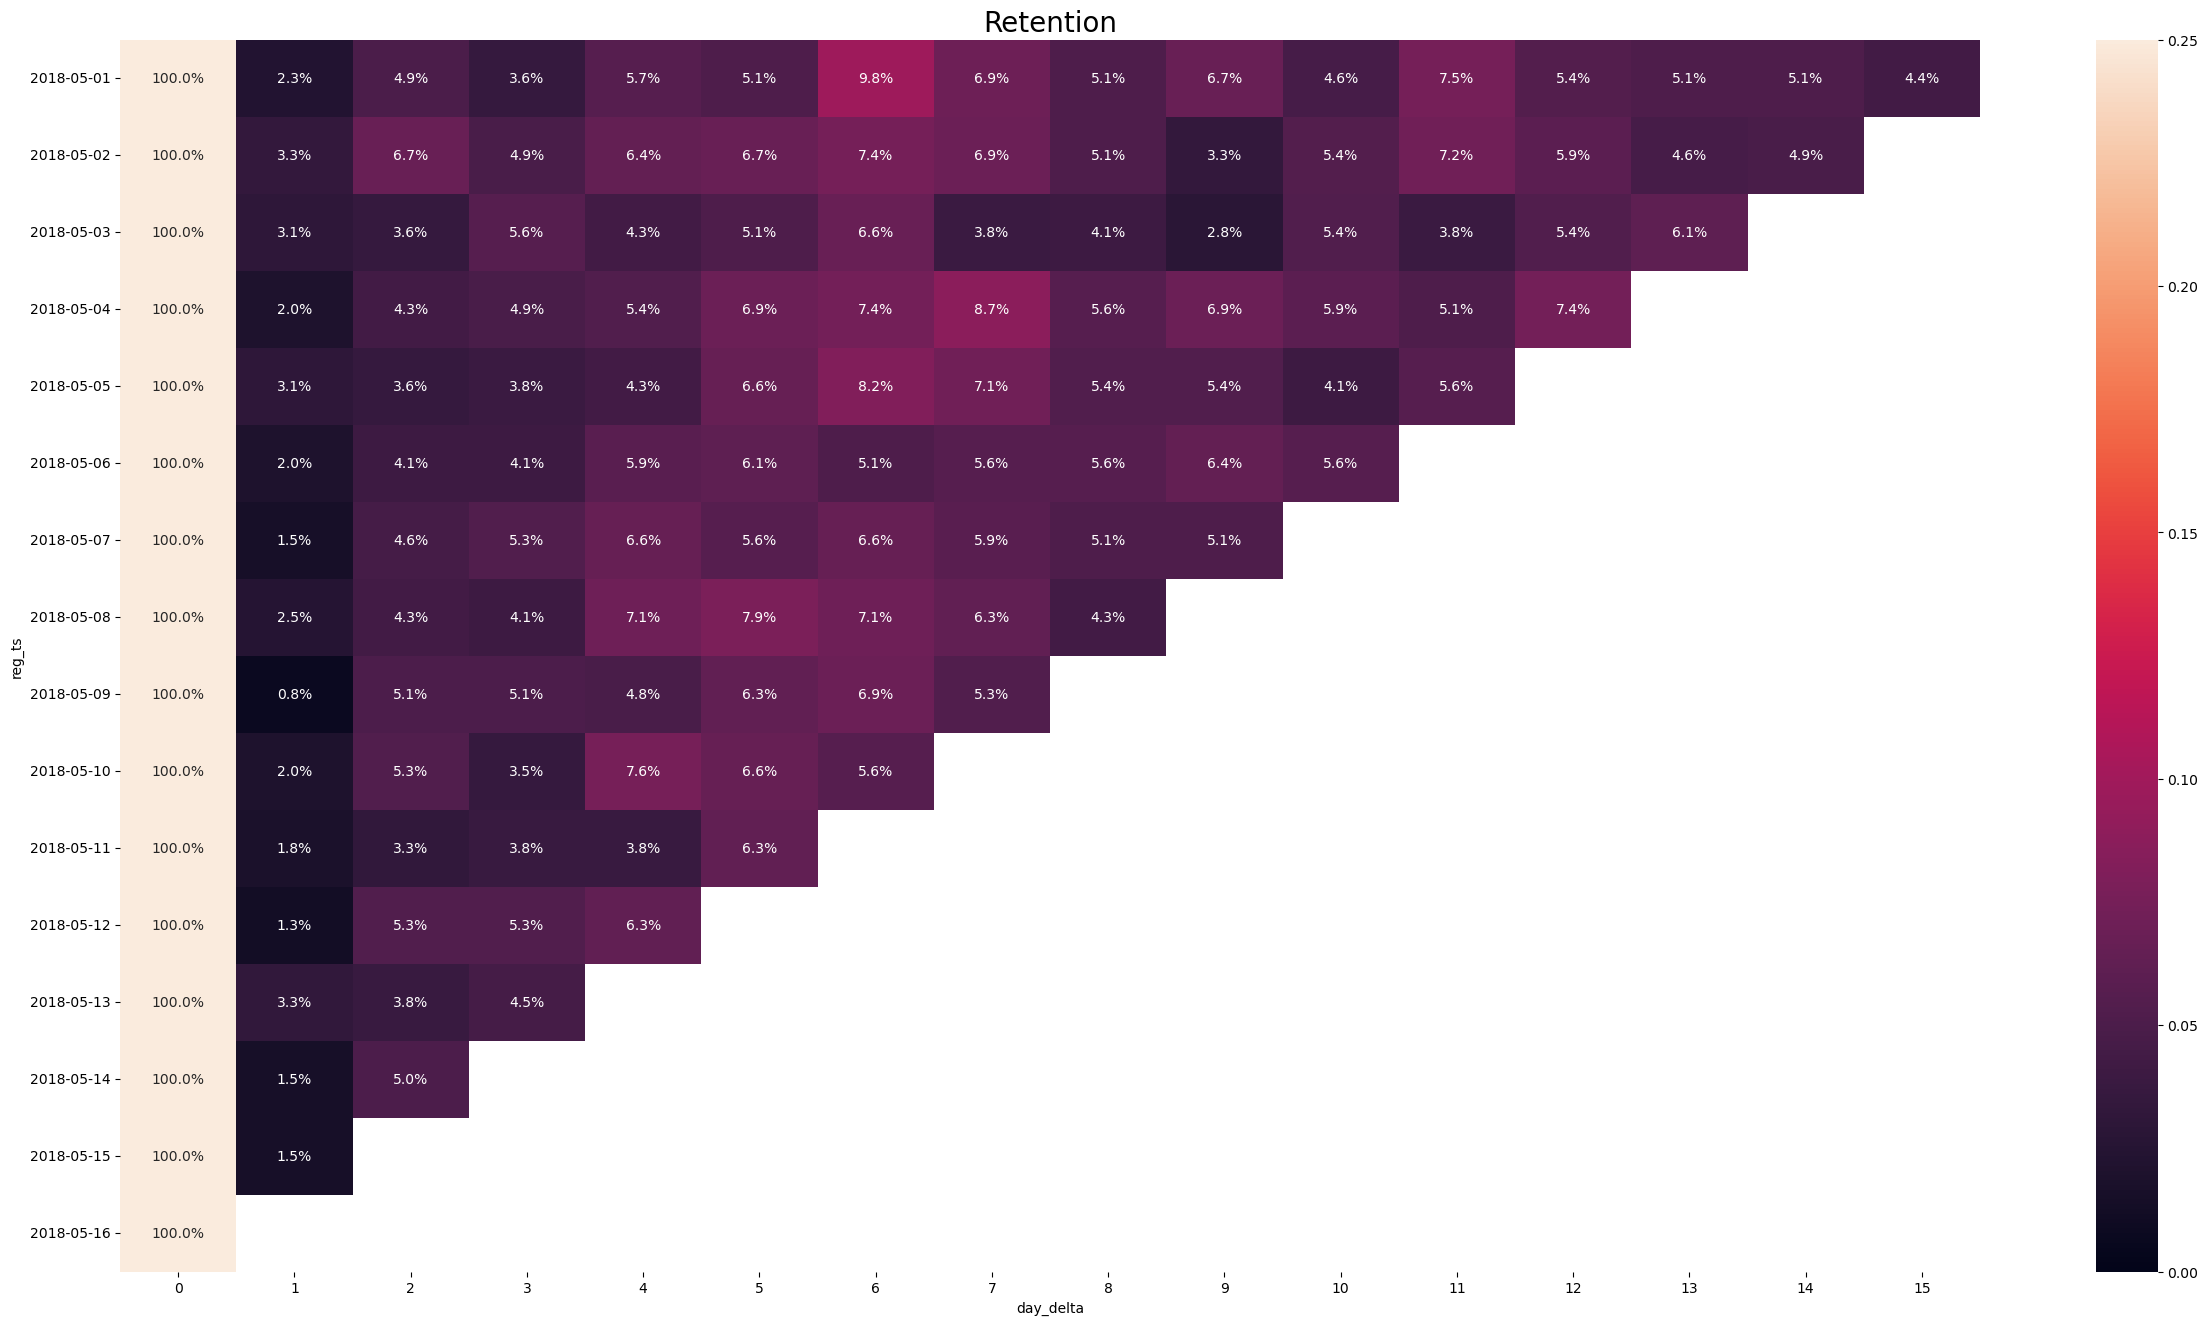

In [18]:
retention(df, begin, days)

# Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [52]:
df = pd.read_csv('Проект_1_Задание_2.csv', encoding = 'windows-1251', sep = ';')
df.head()

user_id  revenue testgroup
0        1        0         b
1        2        0         a
2        3        0         a
3        4        0         b
4        5        0         b

In [53]:
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [54]:
df.duplicated().sum()

0

In [55]:
print('Уникальные пользователи - ', len(df['user_id'].unique()))
print('Тестовые группы - ', len(df['testgroup'].unique()))
print('Минимальный платеж - ', df.revenue.min(), 'Максимальный платеж - ', df.revenue.max())
print(' ')
df.info()

Уникальные пользователи -  404770
Тестовые группы -  2
Минимальный платеж -  0 Максимальный платеж -  37433
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


У нас 2 тестовые группы и нет повторяющихся пользователей.
Чтобы понять какой набор предложений можно считать лучшим, нужно сравнить их между собой.
Какие метрики мы будем использовать:
CR - доля пользователей, которые совершили платеж.
ARPU - средний доход с каждого пользователя.
ARPPU -  средний доход с каждого заплатившего пользователя.

In [56]:
def get_metrics(df):
    df_total = df.groupby('testgroup', as_index=False).agg({'user_id':'count'}).rename(columns={'user_id':'total_users'}) 
    df_revenue = df.groupby('testgroup', as_index=False).agg({'revenue':'sum'}) 
    df_money = df.query('revenue != 0').groupby('testgroup', as_index=False).agg({'user_id':'count'}).rename(columns={'user_id':'total_customers'}) 
    df_metrics = df_total.merge(df_money, on = 'testgroup').merge(df_revenue, on = 'testgroup')
    df_metrics['CR'] = (df_metrics.total_customers/df_metrics.total_users*100).round(2)
    df_metrics['ARPU'] = (df_metrics.revenue/df_metrics.total_users).round(2)
    df_metrics['ARPPU'] = (df_metrics.revenue/df_metrics.total_customers).round(2)
    df_metrics.loc[3] = ['diff',
                   ((df_metrics.total_users[0] - df_metrics.total_users[1])/df_metrics.total_users[1]*100).round(2), 
                   ((df_metrics.total_customers[0] - df_metrics.total_customers[1])/df_metrics.total_customers[1]*100).round(2),
                   ((df_metrics.revenue[0] - df_metrics.revenue[1])/df_metrics.revenue[1]*100).round(2),
                   ((df_metrics.CR[0] - df_metrics.CR[1])/df_metrics.CR[1]*100).round(2),
                   ((df_metrics.ARPU[0] - df_metrics.ARPU[1])/df_metrics.ARPU[1]*100).round(2),
                   ((df_metrics.ARPPU[0] - df_metrics.ARPPU[1])/df_metrics.ARPPU[1]*100).round(2)]
    return df_metrics

In [57]:
df_metrics = get_metrics(df)
df_metrics

testgroup  total_users  total_customers     revenue    CR   ARPU    ARPPU
0         a    202103.00          1928.00  5136189.00  0.95  25.41  2664.00
1         b    202667.00          1805.00  5421603.00  0.89  26.75  3003.66
3      diff        -0.28             6.81       -5.26  6.74  -5.01   -11.31

Выводы по тестовой группе:
Задействовано на 0.28% больше пользователей. 
Общая сумма всех покупок больше на 5.26%.
На 5% выше средний доход на платящего пользователя.
На 11.31% выше средних доход на платящего пользователя.

Вывод по контрольной группе: 
Число заплативших пользователей выше на 6.8%.
Конверция пользователей больше на 6.74%.

<AxesSubplot:xlabel='revenue', ylabel='Count'>

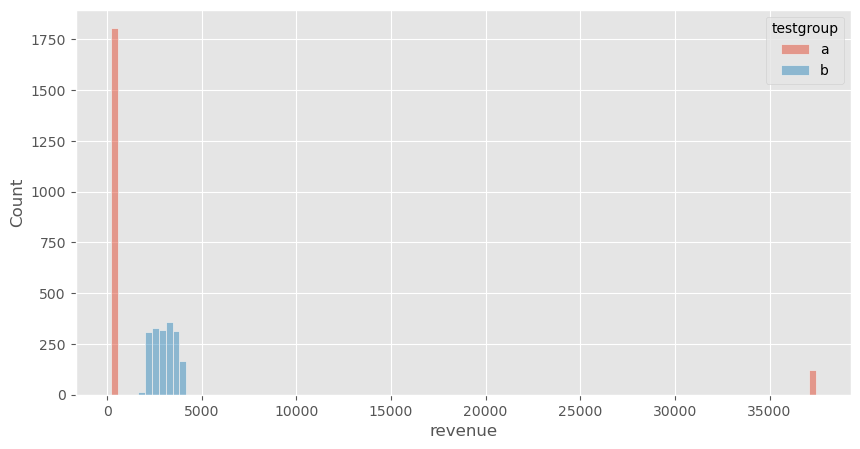

In [58]:
# Распределение платежей в каждой группе

plt.figure(figsize=(10, 5))
sns.histplot(x = 'revenue', data = df.query('revenue != 0'), hue = 'testgroup')

C:\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warni

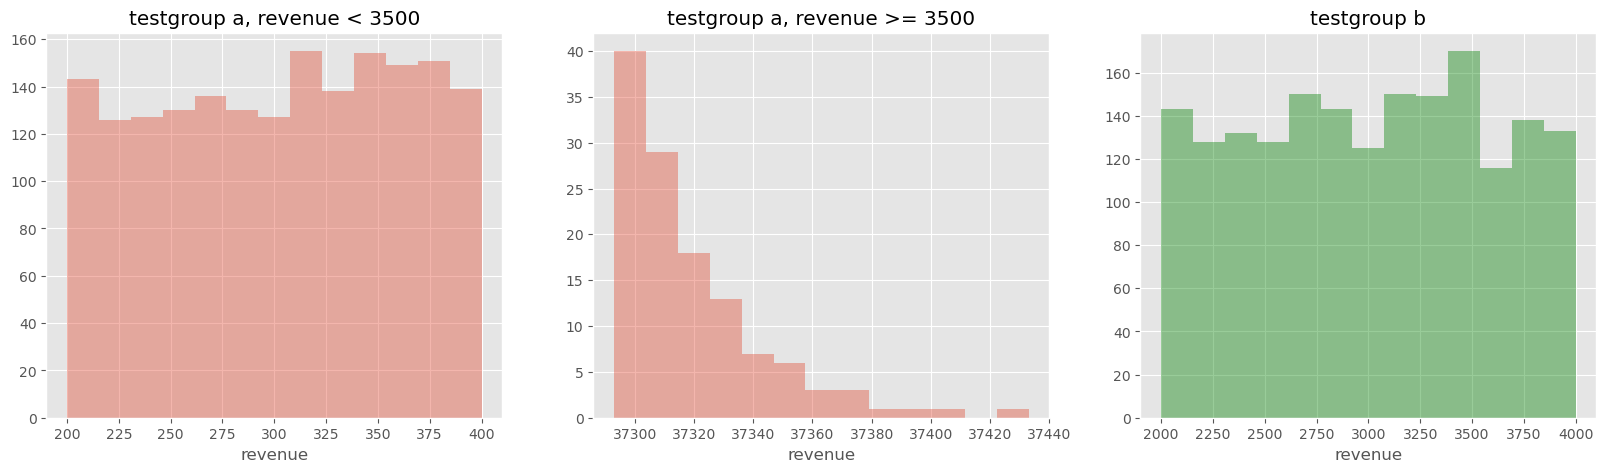

In [59]:
fig, ax = plt.subplots(1,3, figsize=(20, 5))
sns.distplot(df.query('revenue != 0 & testgroup == "a" & revenue < 3500').revenue, kde=False, ax=ax[0]).set_title('testgroup a, revenue < 3500')
sns.distplot(df.query('revenue != 0 & testgroup == "a" & revenue >= 3500').revenue, kde=False, ax=ax[1]).set_title('testgroup a, revenue >= 3500')
sns.distplot(df.query('revenue != 0 & testgroup == "b"').revenue, kde=False, ax=ax[2], color = 'green').set_title('testgroup b')


plt.show()

В распределении виден сильный разброс в платежах контрольной группы и оно не выглядит нормальным.


Разбиваем данные на два датафрейма, чтобы посмотреть по количеству групп.

In [60]:
df_a = df.query('testgroup == "a"')
df_b = df.query('testgroup == "b"')

In [61]:
# Доход пользователей, которые заплатили
    
df_a.query('revenue != 0').revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [62]:
df_a.query('revenue > 3500').sort_values('revenue')

user_id  revenue testgroup
19495     19496    37293         a
81477     81478    37294         a
235858   235859    37294         a
254113   254114    37294         a
34534     34535    37294         a
...         ...      ...       ...
142804   142805    37379         a
21585     21586    37385         a
65077     65078    37394         a
196601   196602    37407         a
101861   101862    37433         a

[123 rows x 3 columns]

In [63]:
df_b.query('revenue != 0').revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

В контрольной группе среднее и медианное значение сильно отличаются.
В тестовой группе среднее и медианное примерно одинаковые.

Так же в контрольной группе стандартное отклонение равно 9049 это значит, что имеется большой разброс значений. 
Распределение платежей не подходит под нормальное. Это значит, что к данным можно примерить метод бутстрап.

## ARPU

Сначала исследуем средний доход по всем пользователям. 
По таблице выше мы уже знаем что в контрольной группе он на 5% выше, чем в тестовой. 
Нам нужно посчитать оправдывает ли эта разница себя. 
Выдвигаем гипотезы:
Н0 - разница в средних значениях в обоих группах отсутствует (при p > 0.05)
Н1 - разница есть (при p < 0.05)

Для подсчета применяем бутстрап:

In [64]:
def get_bootstrap(
    data_column_1, 
    data_column_2,
    boot_it = 1000, 
    statistic = np.mean, 
    bootstrap_conf_level = 0.95 
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): 
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True 
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = ss.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = ss.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
 
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

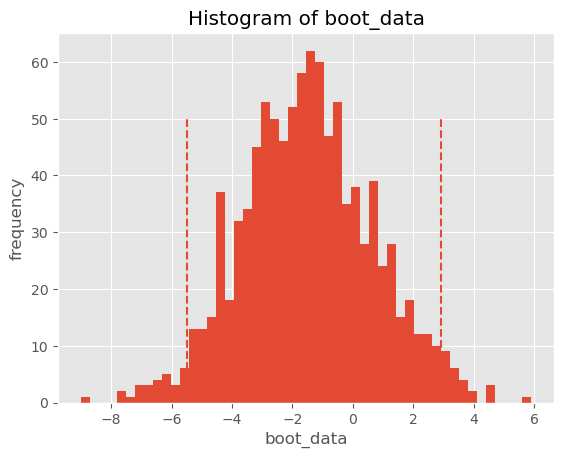

0.49363684554237386

In [65]:
bootstrap_mean_results = get_bootstrap(df_a.revenue, df_b.revenue)
bootstrap_mean_results['p_value']

In [66]:
bootstrap_mean_results['ci']

0
0.025 -5.501261
0.975  2.906199

p > 0.05 и 0 лежит в доверительном интервале. 
Поэтому мы не исключаем нулевую гипотезу о том, что разница в средних значениях в обеих группах отсутствует 

## ARPPU

По таблице выше мы уже знаем, что в контрольной группе она на 11.31% выше, чем в тестовой. 
Нам нужно посчитать оправдывает ли эта разница себя. 
Выдвигаем гипотезы:
Н0 - разница в средних значениях в обоих группах отсутствует (при p > 0.05)
Н1 - разница есть (при p < 0.05)

Для подсчета применяем бутстрап:

In [67]:
df_a_revenue = df_a.query('revenue != 0')
df_b_revenue = df_b.query('revenue != 0')

In [68]:
bootstrap_mean_results = get_bootstrap(df_a_revenue.revenue, df_b_revenue.revenue)
bootstrap_mean_results['p_value']

  0%|          | 0/1000 [00:00<?, ?it/s]

0.1131014307452238

In [69]:
bootstrap_mean_results['ci']

0
0.025 -751.569982
0.975   67.845526

p > 0.05 и 0 лежит в доверительном интервале.
Поэтому мы не исключаем нулевую гипотезу о том, что разница в средних значениях в обеих группах отсутствует.

Попробуем сравнить медиану:

In [70]:
bootstrap_median_results = get_bootstrap(df_a_revenue.revenue, df_b_revenue.revenue, statistic = np.median)
bootstrap_median_results['p_value']

  0%|          | 0/1000 [00:00<?, ?it/s]

0.0

По этим результатам мы отклоняем нулевую гипотезу.

Итог: Результаты A/B-тестирования показали, что значимых статистических различий в контрольной и тестовой группах нет.
Если считать 123 платежа с высокими чеками ошибкой и исключить их из данных, тогда мы можем сделать вывод о том, что новый пакет предложений стоит выкатывать на всех пользователей. Поскольку различия в ARPU без учета выбросов в контрольной группе статистически значимы. Следовательно, новый пакет предложений более прибыльный. Но сложно однозначно сказать, какая группа оказалась лучше. Если бы было больше информации о пользователях, можно было бы попробовать рассчитать другие метрики. В данном случае целесообразно обратиться к бизнесу с полученными результатами и предложить им выбрать между 1 группой, где много мелких клиентов и несколько крупных, или 2ой группой, где доход равномерный, стабильный и достаточно прогнозируемый. И даже с учетом меньшей конверсии ARPPU оказалось больше в В, чем в А. Я считаю, что изменения можно выкатить, так как с точки зрения бизнеса, лучше иметь большое количество среднеплатящих клиентов, чем зависеть от небольшого числа крупных пользователей, при оттоке которых бизнес потеряет больше денег.

P.S. Можно попробовать применить акционное предложение для тестовой группы, так как в случае оттока из контрольной группы пользователей, совершающих дорогие покупки, метрики могут упасть.

# Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Ответ:

#### С помощью каких метрик можно оценить результаты последнего прошедшего события?

- В первую очередь стоит смотреть на конверсию в участие игрока в событии.
- Стоит отслеживать метрики DAU,WAU и MAU в зависимости от длительности ограничений по времени события.
- В долгосрочной перспективе стоит разметить активных пользователей в период действия события на участвовавших в нем и тех, кто не участвовал. Затем в двух когортах провести сравнение retention и ARPU. 

Замер первых двух метрик позволит определить результат привлекательности события и его влияние на удержание внимания пользователей. 
А сравнение retention и ARPU в группах пользователей участвовавших и не участвовавших в событии, позволит оценить его влияние на поведение пользователей.

#### Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

- В данном случае дополнительно понадобится замер retenrion на каждом отдельном уровне. Чтобы оценить сложность уровней и посмотреть на каких уровнях большинство игроков оставляет попытки их пройти.
- Далее понадобится провести исследование CSI после проведения события и собрать обратную связь от участников. Это позволит оценить насколько данное событие позволило повысить или понизить лояльность игроков.
- В долгосрочной перспективе стоит замерить churn rate, retention и ARPU у двух групп активных в период события пользователей, участвовавших и не участвовавших в событии. Это позволит оценить влияние события на пользователей в долгосрочной перспективе. Стало ли больше игроков покидать игру по причине неудовлетворённости новой механикой? Повлияло ли событие на удержание игроков? Повлияло ли событие на увеличение средней выручки с пользователя?